In [ ]:
# ライブラリのインストール
!pip install transformers==4.18.0 fugashi==1.1.0 ipadic==1.0.0 pytorch-lightning==1.6.1

In [ ]:
#8-3
import itertools
import random
import json
from tqdm import tqdm
import numpy as np
import unicodedata
import pprint

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForTokenClassification
import pytorch_lightning as pl

#学習済みモデル
MODEL_NAME = "cl-tohoku/bert-base-japanese-whole-word-masking"

In [ ]:
class NER_tokenizer(BertJapaneseTokenizer):

    def encode_plus_tagged(self, text, entities, max_length):
        """
        文章とそれに含まれる固有表現が与えられた時に、
        符号化とラベル列の作成を行う。
        """
        # 固有表現の前後でtextを分割し、それぞれのラベルをつけておく。
        entities = sorted(entities, key=lambda x: x['span'][0])
        splitted = [] # 分割後の文字列を追加していく
        position = 0
        for entity in entities:
            start = entity['span'][0]
            end = entity['span'][1]
            label = entity['type_id']
            # 固有表現ではないものには0のラベルを付与
            splitted.append({'text':text[position:start], 'label':0})
            # 固有表現には、固有表現のタイプに対応するIDをラベルとして付与
            splitted.append({'text':text[start:end], 'label':label})
            position = end
        splitted.append({'text': text[position:], 'label':0})
        splitted = [ s for s in splitted if s['text'] ] # 長さ0の文字列は除く

        # 分割されたそれぞれの文字列をトークン化し、ラベルをつける。
        tokens = [] # トークンを追加していく
        labels = [] # トークンのラベルを追加していく
        for text_splitted in splitted:
            text = text_splitted['text']
            label = text_splitted['label']
            tokens_splitted = self.tokenize(text)
            labels_splitted = [label] * len(tokens_splitted)
            tokens.extend(tokens_splitted)
            labels.extend(labels_splitted)

        # 符号化を行いBERTに入力できる形式にする。
        input_ids = self.convert_tokens_to_ids(tokens)
        encoding = self.prepare_for_model(
            input_ids,
            max_length=max_length,
            padding='max_length',
            truncation=True
        ) # input_idsをencodingに変換
        # 特殊トークン[CLS]、[SEP]のラベルを0にする。
        labels = [0] + labels[:max_length-2] + [0]
        # 特殊トークン[PAD]のラベルを0にする。
        labels = labels + [0]*( max_length - len(labels) )
        encoding['labels'] = labels

        return encoding

    def encode_plus_untagged(
        self, text, max_length=None, return_tensors=None
    ):
        """
        文章をトークン化し、それぞれのトークンの文章中の位置も特定しておく。
        """
        # 文章のトークン化を行い、
        # それぞれのトークンと文章中の文字列を対応づける。
        tokens = [] # トークンを追加していく。
        tokens_original = [] # トークンに対応する文章中の文字列を追加していく。
        words = self.word_tokenizer.tokenize(text) # MeCabで単語に分割
        for word in words:
            # 単語をサブワードに分割
            tokens_word = self.subword_tokenizer.tokenize(word)
            tokens.extend(tokens_word)
            if tokens_word[0] == '[UNK]': # 未知語への対応
                tokens_original.append(word)
            else:
                tokens_original.extend([
                    token.replace('##','') for token in tokens_word
                ])

        # 各トークンの文章中での位置を調べる。（空白の位置を考慮する）
        position = 0
        spans = [] # トークンの位置を追加していく。
        for token in tokens_original:
            l = len(token)
            while 1:
                if token != text[position:position+l]:
                    position += 1
                else:
                    spans.append([position, position+l])
                    position += l
                    break

        # 符号化を行いBERTに入力できる形式にする。
        input_ids = self.convert_tokens_to_ids(tokens)
        encoding = self.prepare_for_model(
            input_ids,
            max_length=max_length,
            padding='max_length' if max_length else False,
            truncation=True if max_length else False
        )
        sequence_length = len(encoding['input_ids'])
        # 特殊トークン[CLS]に対するダミーのspanを追加。
        spans = [[-1, -1]] + spans[:sequence_length-2]
        # 特殊トークン[SEP]、[PAD]に対するダミーのspanを追加。
        spans = spans + [[-1, -1]] * ( sequence_length - len(spans) )

        # 必要に応じてtorch.Tensorにする。
        if return_tensors == 'pt':
            encoding = { k: torch.tensor([v]) for k, v in encoding.items() }

        return encoding, spans

    def convert_bert_output_to_entities(self, text, labels, spans):
        """
        文章、ラベル列の予測値、各トークンの位置から固有表現を得る。
        """
        # labels, spansから特殊トークンに対応する部分を取り除く
        labels = [label for label, span in zip(labels, spans) if span[0] != -1]
        spans = [span for span in spans if span[0] != -1]

        # 同じラベルが連続するトークンをまとめて、固有表現を抽出する。
        entities = []
        for label, group \
            in itertools.groupby(enumerate(labels), key=lambda x: x[1]):

            group = list(group)
            start = spans[group[0][0]][0]
            end = spans[group[-1][0]][1]

            if label != 0: # ラベルが0以外ならば、新たな固有表現として追加。
                entity = {
                    "name": text[start:end],
                    "span": [start, end],
                    "type_id": label
                }
                entities.append(entity)

        return entities

In [ ]:
#8-14
#データロード
load_data_name = 'json_name.json'
dataset = json.load(open(f'/path/to/{load_data_name}','r'))

type_id_dict = {
    "技術語": 1,
}

#カテゴリをラベルに、テキストの正規化
for sample in dataset:
  sample['text'] = unicodedata.normalize('NFKC', sample['text'])
  for e in sample["entities"]:
    e['type_id'] = type_id_dict[e['type']]
    del e['type']

#データセットの分割
random.seed(314)
random.shuffle(dataset)
n = len(dataset)
n_train = int(n*0.6)
n_val = int(n*0.2)
dataset_train = dataset[:n_train] #学習用
dataset_val = dataset[n_train:n_train+n_val]  #検証用
dataset_test = dataset[n_train+n_val:] #テスト用

In [ ]:
#8-15
def create_dataset(tokenizer, dataset, max_length):
  dataset_for_loader = []
  for sample in dataset:
    text = sample['text']
    entities = sample['entities']
    encoding = tokenizer.encode_plus_tagged(
        text, entities, max_length=max_length
    )
    encoding = {k: torch.tensor(v) for k, v in encoding.items()}
    dataset_for_loader.append(encoding)
  return dataset_for_loader

tokenizer = NER_tokenizer.from_pretrained(MODEL_NAME)

#データセットの作成
max_length = 256
dataset_train_for_loader = create_dataset(
    tokenizer, dataset_train, max_length
)
dataset_val_for_loader = create_dataset(
    tokenizer, dataset_val, max_length
)

#データローダの作成
dataloader_train = DataLoader(
    dataset_train_for_loader, batch_size=32, shuffle=True
)
dataloader_val = DataLoader(dataset_val_for_loader, batch_size=256)

In [ ]:
# 8-16
# PyTorch Lightningのモデル
class BertForTokenClassification_pl(pl.LightningModule):

    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters()
        self.bert_tc = BertForTokenClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

    def training_step(self, batch, batch_idx):
        output = self.bert_tc(**batch)
        loss = output.loss
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self.bert_tc(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='model/'
)

trainer = pl.Trainer(
    gpus=1,
    max_epochs=5,
    callbacks=[checkpoint]
)

# ファインチューニング
model = BertForTokenClassification_pl(
    MODEL_NAME, num_labels=2, lr=1e-5
)
trainer.fit(model, dataloader_train, dataloader_val)
best_model_path = checkpoint.best_model_path

In [ ]:
# 8-17
def predict(text, tokenizer, bert_tc):
    """
    BERTで固有表現抽出を行うための関数。
    """
    # 符号化
    encoding, spans = tokenizer.encode_plus_untagged(
        text, return_tensors='pt'
    )
    encoding = { k: v.cuda() for k, v in encoding.items() }

    # ラベルの予測値の計算
    with torch.no_grad():
        output = bert_tc(**encoding)
        scores = output.logits
        labels_predicted = scores[0].argmax(-1).cpu().numpy().tolist()

    # ラベル列を固有表現に変換
    entities = tokenizer.convert_bert_output_to_entities(
        text, labels_predicted, spans
    )

    return entities

# トークナイザのロード
tokenizer = NER_tokenizer.from_pretrained(MODEL_NAME)

# ファインチューニングしたモデルをロードし、GPUにのせる。
model = BertForTokenClassification_pl.load_from_checkpoint(
    best_model_path
)
bert_tc = model.bert_tc.cuda()

# 固有表現抽出
# 注：以下ではコードのわかりやすさのために、1データづつ処理しているが、
# バッチ化して処理を行った方が処理時間は短い
entities_list = [] # 正解の固有表現を追加していく。
entities_predicted_list = [] # 抽出された固有表現を追加していく。
for sample in tqdm(dataset_test):
    text = sample['text']
    entities_predicted = predict(text, tokenizer, bert_tc) # BERTで予測
    entities_list.append(sample['entities'])
    entities_predicted_list.append( entities_predicted )
    #print(text)
    #print(entities_predicted)

In [ ]:
print("# 正解")
print(entities_list[0])
print("# 抽出")
print(entities_predicted_list[0])

In [ ]:
# 8-19
def evaluate_model(entities_list, entities_predicted_list, type_id=None):
    """
    正解と予測を比較し、モデルの固有表現抽出の性能を評価する。
    type_idがNoneのときは、全ての固有表現のタイプに対して評価する。
    type_idが整数を指定すると、その固有表現のタイプのIDに対して評価を行う。
    """
    num_entities = 0 # 固有表現(正解)の個数
    num_predictions = 0 # BERTにより予測された固有表現の個数
    num_correct = 0 # BERTにより予測のうち正解であった固有表現の数

    # それぞれの文章で予測と正解を比較。
    # 予測は文章中の位置とタイプIDが一致すれば正解とみなす。
    for entities, entities_predicted \
        in zip(entities_list, entities_predicted_list):

        if type_id:
            entities = [ e for e in entities if e['type_id'] == type_id ]
            entities_predicted = [
                e for e in entities_predicted if e['type_id'] == type_id
            ]

        get_span_type = lambda e: (e['span'][0], e['span'][1], e['type_id'])
        set_entities = set( get_span_type(e) for e in entities )
        set_entities_predicted = \
            set( get_span_type(e) for e in entities_predicted )

        num_entities += len(entities)
        num_predictions += len(entities_predicted)
        num_correct += len( set_entities & set_entities_predicted )

    # 指標を計算
    precision = num_correct/num_predictions # 適合率
    recall = num_correct/num_entities # 再現率
    f_value = 2*precision*recall/(precision+recall) # F値

    result = {
        'num_entities': num_entities,
        'num_predictions': num_predictions,
        'num_correct': num_correct,
        'precision': precision,
        'recall': recall,
        'f_value': f_value
    }

    return result

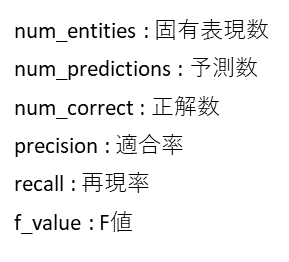

In [ ]:
#8-20
#性能評価
pprint.pprint(evaluate_model(entities_list, entities_predicted_list), indent=3, sort_dicts=False)

In [ ]:
# 抽出データ比較用CSV生成
import pandas as pd
n = 0
list_for_df = []
for predictions, corrections, sample in zip(entities_predicted_list, entities_list, dataset_test):
  n += 1
  s_name = sample['text']
  p_lst = []
  c_lst = []
  for p in predictions:
    p_lst.append(p['name'])
  for c in corrections:
    c_lst.append(c['name'])
  while len(c_lst) != len(p_lst):
    if len(c_lst) > len(p_lst):
      p_lst.append("[hoge]")
    else:
      c_lst.append("[hoge]")
  i = 0
  for c_token, p_token in zip(c_lst, p_lst):
    dict_for_df = {}
    i += 1
    t_name = "token" + str(i)
    dict_for_df['sentence'] = s_name
    dict_for_df['token'] = t_name
    dict_for_df['correct'] = c_token
    dict_for_df['predicted'] = p_token
    list_for_df.append(dict_for_df)
df = pd.DataFrame(list_for_df)
df.to_csv("result.csv", index=None, encoding="shift-jis")